# Tutorial 7: DLPFC interpolation(huge_diff)
This tutorial primarily describes the process of using samples 151671 and 151673 to impute 151672.

## Environment Configuration & Package Loading

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from GenOT import GenOT
import jax.numpy as jnp
import numpy as np
from scipy.sparse import issparse
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'
os.environ['PATH'] = 'C:/Program Files/R/R-4.4.1/bin/x64;' + os.environ['PATH']

## Data Loading

In [3]:
section_id = '151671'
input_dir = os.path.join('../Data', section_id)
adata1 = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
# adata1 = sc.pp.subsample(adata1, n_obs=3000, random_state=0, copy=True)
adata1.var_names_make_unique(join="++")
print(adata1)
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata1.obs['Ground Truth'] = Ann_df.loc[adata1.obs_names, 'Ground Truth'].astype('category')

section_id = '151673'
input_dir = os.path.join('../Data', section_id)
adata2 = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
# adata2 = sc.pp.subsample(adata2, n_obs=3000, random_state=0, copy=True)
adata2.var_names_make_unique(join="++")
print(adata2)
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata2.obs['Ground Truth'] = Ann_df.loc[adata2.obs_names, 'Ground Truth'].astype('category')

section_id = '151672'
input_dir = os.path.join('../Data', section_id)
adata3 = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
# adata3 = sc.pp.subsample(adata3, n_obs=3000, random_state=0, copy=True)
adata3.var_names_make_unique(join="++")
print(adata3)
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata3.obs['Ground Truth'] = Ann_df.loc[adata3.obs_names, 'Ground Truth'].astype('category')

AnnData object with n_obs × n_vars = 4110 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 4015 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
adata3.n_obs

4015

## normalize

In [5]:
from GenOT.utils import normalize_sparse

adata1 = normalize_sparse(adata1)
adata2 = normalize_sparse(adata2)
adata3 = normalize_sparse(adata3)

## Visualize adata1, adata2, and adata3.

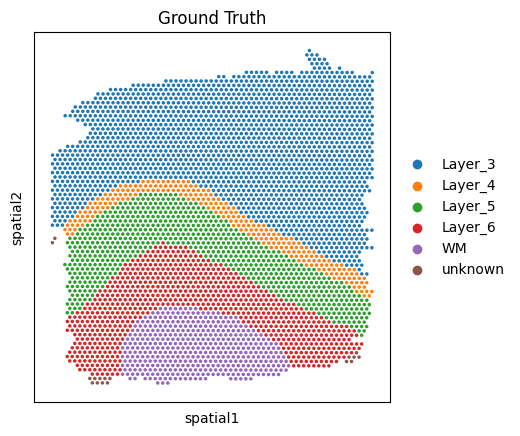

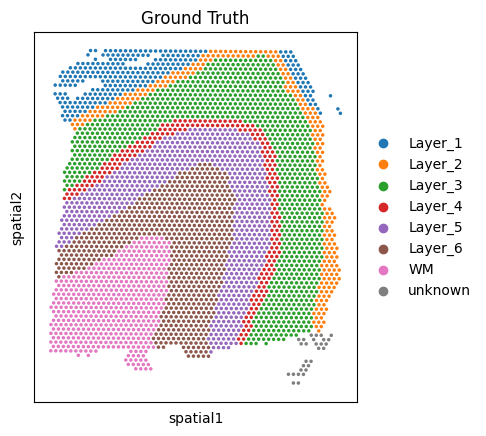

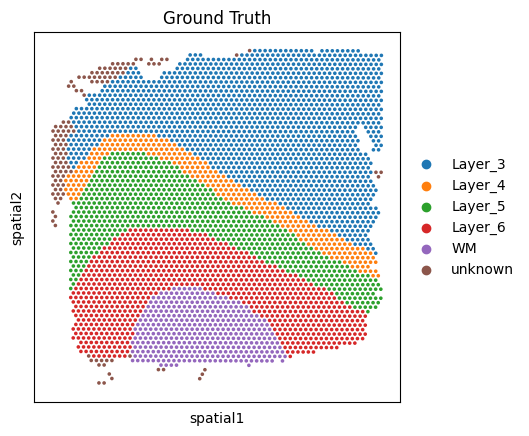

In [6]:
sc.pl.spatial(adata1, img_key=None, color='Ground Truth')
sc.pl.spatial(adata2, img_key=None, color='Ground Truth')
sc.pl.spatial(adata3, img_key=None, color='Ground Truth')

## Align the input datasets adata1 and adata2 using the PASTE2 algorithm.

PASTE2 starts...
Starting GLM-PCA...
Iteration: 0 | deviance=4.3054E+6
Iteration: 1 | deviance=4.3054E+6
Iteration: 2 | deviance=4.2363E+6
Iteration: 3 | deviance=4.1154E+6
Iteration: 4 | deviance=4.0127E+6
Iteration: 5 | deviance=3.9719E+6
Iteration: 6 | deviance=3.9529E+6
Iteration: 7 | deviance=3.9424E+6
Iteration: 8 | deviance=3.9357E+6
Iteration: 9 | deviance=3.9309E+6
Iteration: 10 | deviance=3.9272E+6
Iteration: 11 | deviance=3.9243E+6
Iteration: 12 | deviance=3.9219E+6
Iteration: 13 | deviance=3.9199E+6
Iteration: 14 | deviance=3.9182E+6
Iteration: 15 | deviance=3.9167E+6
Iteration: 16 | deviance=3.9154E+6
Iteration: 17 | deviance=3.9142E+6
Iteration: 18 | deviance=3.9132E+6
Iteration: 19 | deviance=3.9122E+6
Iteration: 20 | deviance=3.9114E+6
Iteration: 21 | deviance=3.9106E+6
Iteration: 22 | deviance=3.9099E+6
Iteration: 23 | deviance=3.9093E+6
Iteration: 24 | deviance=3.9087E+6
Iteration: 25 | deviance=3.9081E+6
Iteration: 26 | deviance=3.9076E+6
Iteration: 27 | deviance=3.9

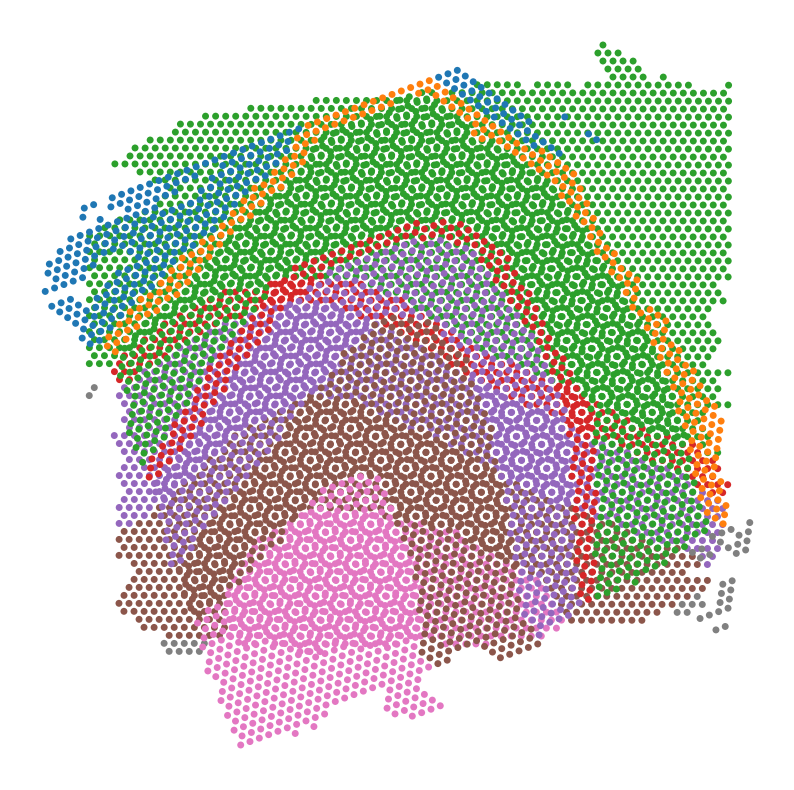

In [7]:
from GenOT.utils import PASTE2_align_spatial_data, visualize_alignment

adata1.obsm['spatial'], adata2.obsm['spatial'] = PASTE2_align_spatial_data(adata1, adata2, visualize=True)


## Data Preprocessing

In [17]:
from GenOT.utils import find_hvg_somde

#
# hvg_gene_names = find_hvg_somde(
#     adata2,
#     save_output=True,  #save txt
#     filename="151673"  #name
# )
with open("../151673_hvg_gene_names(SOM).txt", "r") as file:
    hvg_gene_names = [line.strip() for line in file]

common_genes = set(hvg_gene_names) & set(adata1.var_names) & set(adata2.var_names) & set(adata3.var_names)
matching_genes = list(common_genes)

adata1 = adata1[:, matching_genes].copy()
adata2 = adata2[:, matching_genes].copy()
adata3 = adata3[:, matching_genes].copy()

## Run GenOT

In [13]:
# define model
Encoder = GenOT.DualEncoder(adata1, adata2, device=device, pca_n=16)



In [14]:
adata1, adata2 = Encoder.train_encoder()


Training DualEncoder on 2 datasets with 700 epochs...


Training: 100%|██████████| 700/700 [00:24<00:00, 28.38it/s]

Training completed!


 Compute the spatial barycenter. Precomputed barycenters are available for download [here]. Alternatively, run the annotated code to calculate the spatial barycenter.

In [18]:
from GenOT.utils import compute_spatial_barycenter, compute_emb_barycenter

Xb_s = compute_spatial_barycenter(adata1, adata2, weight1=0.5, num_barycenters=adata3.n_obs, alpha=0.5)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.682111e+07|0.000000e+00|0.000000e+00
    1|1.547955e+07|8.666671e-02|1.341562e+06
    2|1.547955e+07|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.535087e+07|0.000000e+00|0.000000e+00
    1|1.378076e+07|1.139353e-01|1.570115e+06
    2|1.378076e+07|0.000000e+00|0.000000e+00
It.  |Err         
-------------------
    0|1.431172e+07|
    0|1.720989e+05|
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.427633e+07|0.000000e+00|0.000000e+00
    1|1.990544e+06|6.172075e+00|1.228579e+07
    2|1.978427e+06|6.124563e-03|1.211700e+04
    3|1.978427e+06|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.330731e+07|0.000000e+00|0.000000e+00
    1|1.633170e+06|7.148145e+00|1.167414e+

## Train a decoder using SpatialDE HVGs to derive SpaGCN HVGs.

In [19]:
decoder = GenOT.Decoder(
    input_size=adata1.obsm['emb'].shape[1],  # Input dimension
    output_size=adata1.X.shape[1],  # Output dimension
)
# Train the decoder
trained_decoder = decoder.train_decoder(adata1, adata2, decoder, epochs=500, batch_size=2048)

100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


In [20]:
embd0 = adata1.obsm['emb']
embd1 = adata2.obsm['emb']

## Compute the embedding barycenter for the latent representations.

In [21]:


Xb = compute_emb_barycenter(
    adata1, adata2,
    weight1=0.5,
    alpha=0.5,
    num_barycenters=adata3.n_obs,

)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.573326e+02|0.000000e+00|0.000000e+00
    1|5.567271e+02|5.399512e-01|3.006055e+02
    2|5.567271e+02|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.170946e+03|0.000000e+00|0.000000e+00
    1|8.450339e+02|3.856796e-01|3.259123e+02
    2|8.450339e+02|0.000000e+00|0.000000e+00
It.  |Err         
-------------------
    0|2.591250e+04|
    0|2.175153e+03|
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.357555e+02|0.000000e+00|0.000000e+00
    1|1.643241e+02|1.043252e+00|1.714314e+02
    2|1.643241e+02|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.543050e+02|0.000000e+00|0.000000e+00
    1|2.230553e+02|1.036737e+00|2.312496e+02
    2|2.230553e+02|0.000000e+00|0.000000e+

Since the spatial barycenter and embedding barycenter reside in different spaces (not one-to-one cell correspondences), we align them by constraining the embedding barycenter. Refer to the [update_embedding_barycenter] function for details.

In [23]:

from GenOT.utils import update_embedding_barycenter

Xb = update_embedding_barycenter(Xb_s, Xb, adata1, adata2, embd0, embd1)


## Use the trained decoder to transform the embedding barycenter into gene expression values.

In [24]:
new_embedding = torch.tensor(Xb, dtype=torch.float32)
new_embedding = new_embedding.to("cuda" if torch.cuda.is_available() else "cpu")

trained_decoder.eval()
with torch.no_grad():
    reconstructed_features = trained_decoder(new_embedding)

reconstructed_gene_expression = reconstructed_features.cpu().numpy()

print("Reconstructed Features Shape:", reconstructed_gene_expression.shape)


Reconstructed Features Shape: (4015, 14029)


Create a new adata object where the gene expression matrix equals the generated expression values, and spatial coordinates match the spatial barycenter.

In [25]:
new_adata = adata3.copy()
new_adata.X = reconstructed_gene_expression
new_adata.obsm['spatial'] = Xb_s

Map the generated gene expression data to the target dataset using the [create_mapped_adata] function.

In [34]:
from GenOT.utils import create_mapped_adata

#
mapped_adata = create_mapped_adata(new_adata, adata3, threshold_denominator=2)



 Visualize the mapped data, original datasets (adata1/151671 and adata2/151673), and the imputed dataset (adata3/151672)

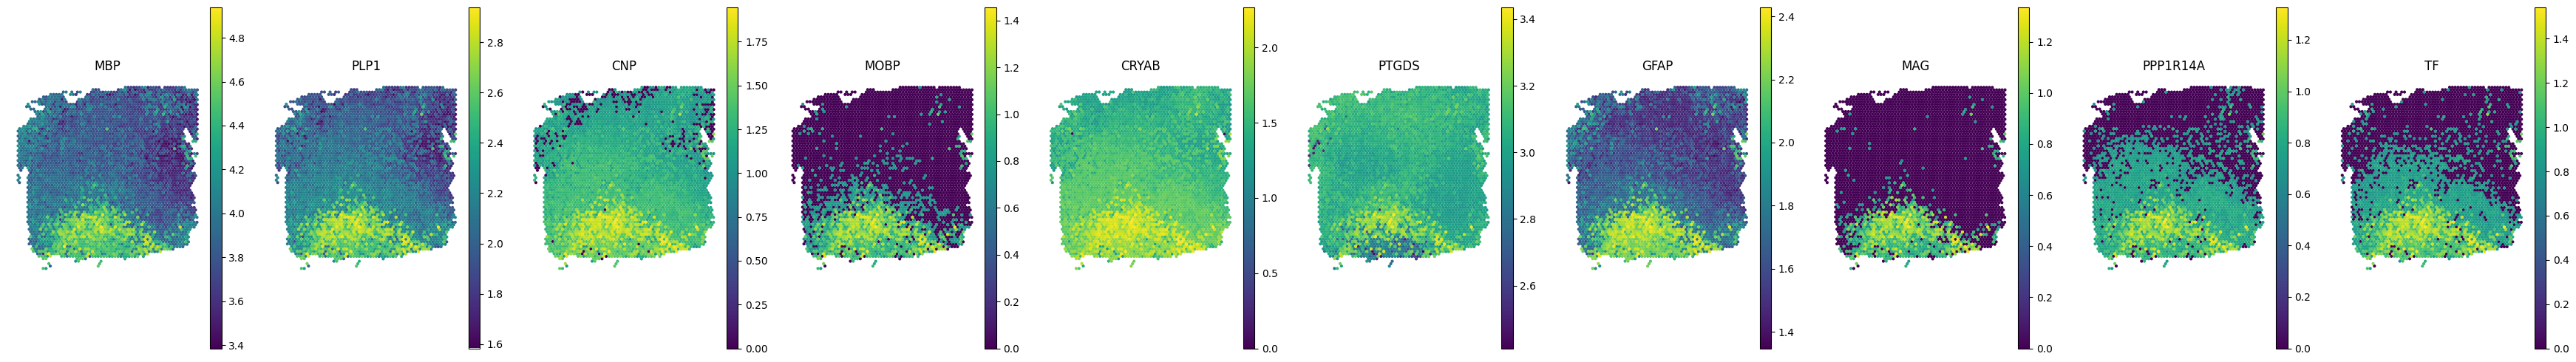

In [35]:
import matplotlib.pyplot as plt
import scanpy as sc

import random

genes_of_interest = list(hvg_gene_names)[:10]

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        mapped_adata,
        color=gene,
        ax=axes[i],
        title=gene,
        show=False,
        size=1.5,
        spot_size=100,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()




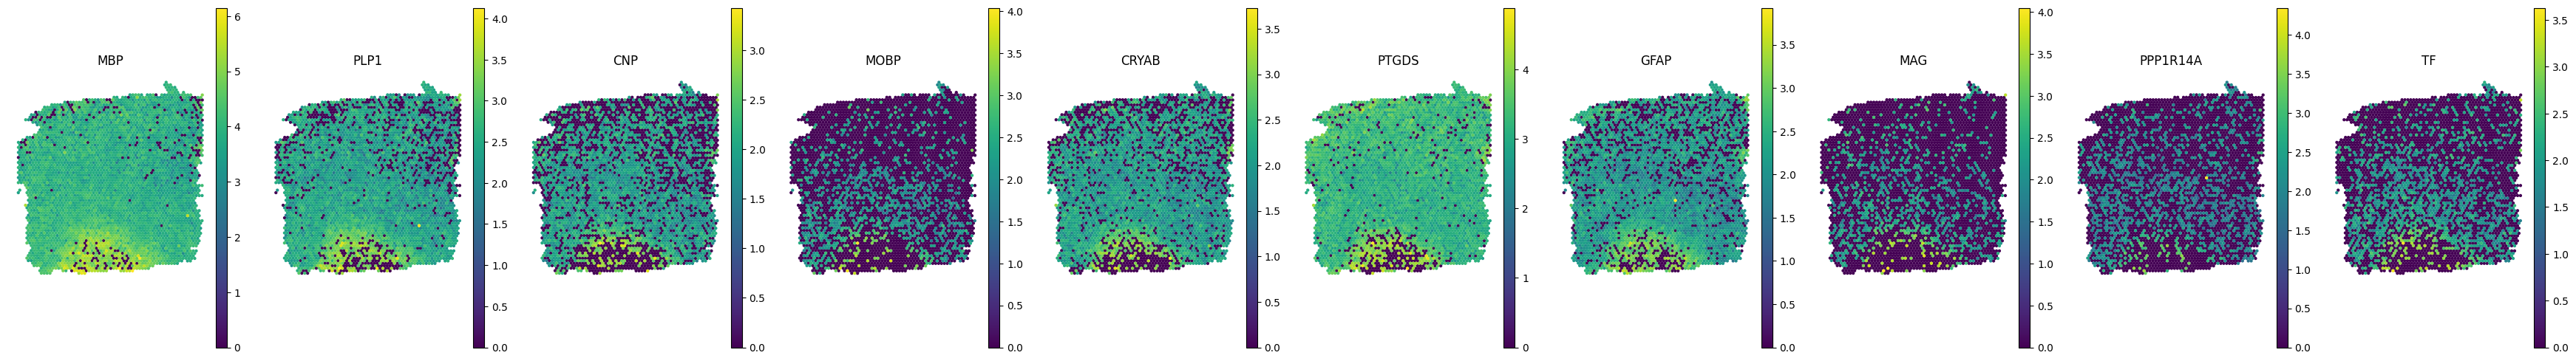

In [36]:

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        adata1,
        color=gene,
        ax=axes[i],
        img_key=None,
        title=gene,
        show=False,
        size=1.5,
        spot_size=100,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()

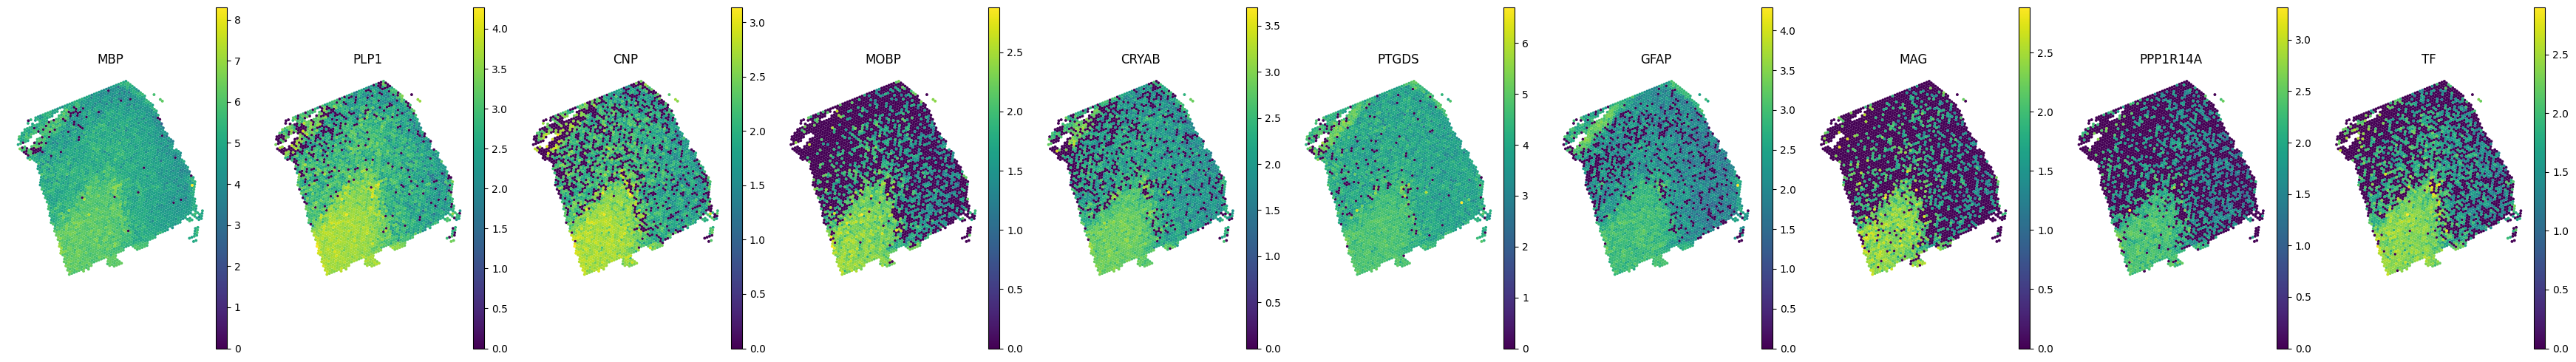

In [37]:


fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        adata2,
        color=gene,
        img_key=None,
        ax=axes[i],
        show=False,
        size=1.5,
        spot_size=100,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()

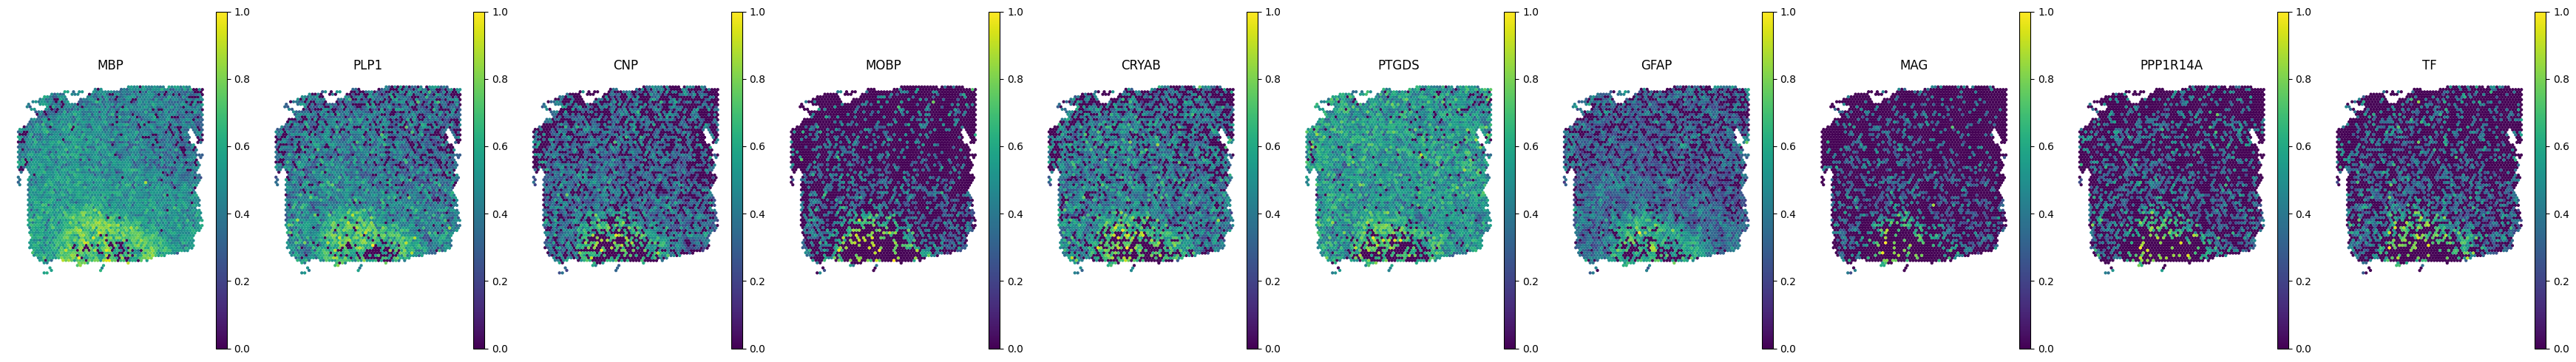

In [38]:

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        adata3,
        img_key=None,
        color=gene,
        ax=axes[i],
        title=gene,
        show=False,
        size=1.5,
        spot_size=100,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()

## Visualize the PCP4 gene expression across datasets.

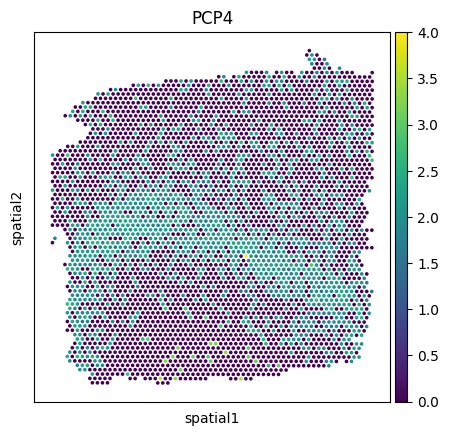

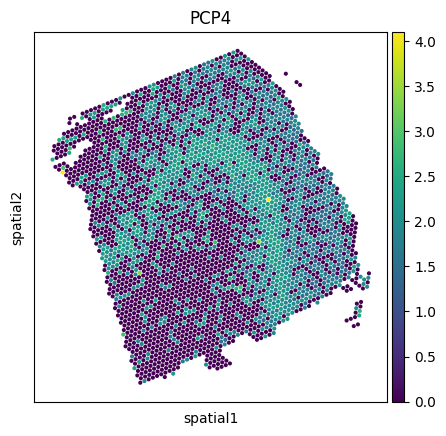

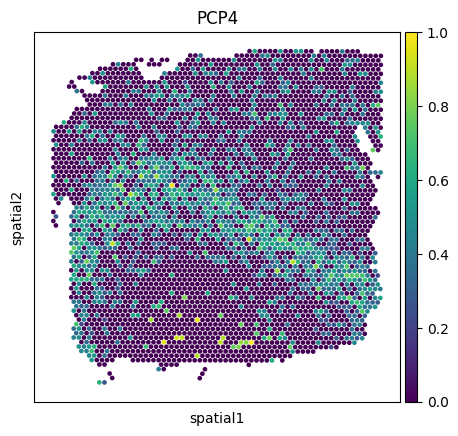

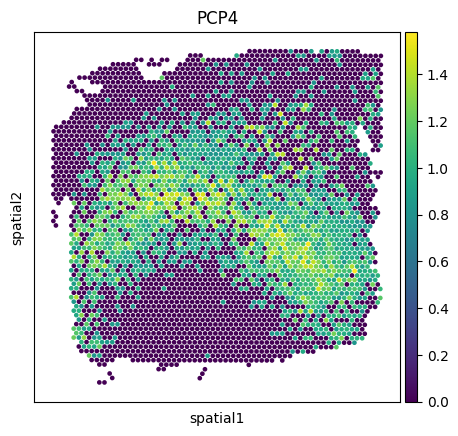

In [39]:
sc.pl.spatial(adata1, img_key=None, color='PCP4', cmap='viridis', size=2, spot_size=50)
sc.pl.spatial(adata2, img_key=None, color='PCP4', cmap='viridis', size=2.5, spot_size=50)
sc.pl.spatial(adata3, img_key=None, color='PCP4', cmap='viridis', size=2.5, spot_size=50)
sc.pl.spatial(mapped_adata, img_key=None, color='PCP4', cmap='viridis', size=2.5, spot_size=50)

In [40]:
import numpy as np
from scipy.stats import pearsonr
from scipy.sparse import issparse

common_genes = mapped_adata.var_names.intersection(adata3.var_names)
a1 = mapped_adata[:, common_genes].copy()
a3 = adata3[:, common_genes].copy()
sc.pp.normalize_total(a1, target_sum=1e4)
sc.pp.normalize_total(a3, target_sum=1e4)

sc.pp.log1p(a1)
sc.pp.log1p(a3)

X1 = a1.X.T
X2 = a3.X.T

if issparse(X1):
    X1 = X1.toarray()
if issparse(X2):
    X2 = X2.toarray()

pcc_values = []
for i in range(X1.shape[0]):
    r, _ = pearsonr(X1[i], X2[i])
    pcc_values.append(r)
pcc_values = np.array(pcc_values)

pcc_values = np.nan_to_num(pcc_values, nan=0.0)

cos_values = np.sum(X1 * X2, axis=1) / (
        np.linalg.norm(X1, axis=1) * np.linalg.norm(X2, axis=1)
)
cos_values = np.nan_to_num(cos_values, nan=0.0)

avg_pcc = np.mean(pcc_values)
avg_cos = np.mean(cos_values)

print(f"平均基因皮尔逊相关系数 (PCC): {avg_pcc:.4f}")
print(f"平均基因余弦相似度: {avg_cos:.4f}")

平均基因皮尔逊相关系数 (PCC): 0.0099
平均基因余弦相似度: 0.0709


In [41]:
import numpy as np
from scipy.stats import pearsonr
from scipy.sparse import issparse
import scanpy as sc

common_genes = mapped_adata.var_names.intersection(adata3.var_names)
a1 = mapped_adata[:, common_genes].copy()
a3 = adata3[:, common_genes].copy()
sc.pp.normalize_total(a1, target_sum=1e4)
sc.pp.normalize_total(a3, target_sum=1e4)

sc.pp.log1p(a1)
sc.pp.log1p(a3)

X1 = a1.X
X2 = a3.X

if issparse(X1):
    X1 = X1.toarray()
if issparse(X2):
    X2 = X2.toarray()

assert X1.shape[0] == X2.shape[0], "两个数据集的细胞数量不一致"

pcc_values = []
for i in range(X1.shape[0]):
    r, _ = pearsonr(X1[i], X2[i])
    pcc_values.append(r)
pcc_values = np.array(pcc_values)

pcc_values = np.nan_to_num(pcc_values, nan=0.0)

cos_values = np.sum(X1 * X2, axis=1) / (
        np.linalg.norm(X1, axis=1) * np.linalg.norm(X2, axis=1)
)
cos_values = np.nan_to_num(cos_values, nan=0.0)

avg_pcc = np.mean(pcc_values)
avg_cos = np.mean(cos_values)

print(f"所有细胞的平均皮尔逊相关系数 (PCC): {avg_pcc:.4f}")
print(f"所有细胞的平均余弦相似度: {avg_cos:.4f}")

所有细胞的平均皮尔逊相关系数 (PCC): 0.6883
所有细胞的平均余弦相似度: 0.7035
